In [1]:
import torch 
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, Linear, ReLU, Sequential
import cv2
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import pandas as pd
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt
# from torchvision.models import resnet18
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [2]:
# DATA_PATH = "/kaggle/input/unibuc-ml-202325/"
DATA_PATH = "../data/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'num_classes': 96,
    'dropout': 0.5,
    'trained_epochs': 0,
    'patience': 3,
    'image_size': (224, 224),
    'best': 0,
    'model_path': '../models/model_resnet18.pth',
    'model_name': 'ResNet18',
    'augmentation': True,
    'criterion': CrossEntropyLoss(),
}

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = pd.read_csv(csv_file)
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return (image, label)    

In [4]:
class TestImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.df.iloc[index, 0]
        img_path = os.path.join(self.img_dir, img_id)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return (image, img_id)


In [5]:
# for more image transforms  https://pytorch.org/vision/stable/transforms.html

# transforms

img_size = hyperparameters['image_size']

original_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

horizontal_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

vertical_flip_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

gaussian_blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.GaussianBlur(5, sigma=(0.1, 1.0)),
    transforms.ToTensor()
])

translation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

noise_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.1),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

rotation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

color_jitter_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor()
])

resized_crop_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

extend_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [6]:
# datasets

original_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=original_transform)
horizontal_flip_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=horizontal_flip_transform)
rotation_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=rotation_transform)
color_jitter_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=color_jitter_transform)
resized_crop_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=resized_crop_transform)
vertical_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=vertical_flip_transform)
gaussian_blur_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=gaussian_blur_transform)
translation_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=translation_transform)
noise_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=noise_transform)
extend_dataset = CustomImageDataset(img_dir=DATA_PATH + "train_images", csv_file=DATA_PATH + "train.csv", transform=extend_transform)

In [7]:
train_dataset = original_dataset
if hyperparameters['augmentation'] == True:
    train_dataset = ConcatDataset([original_dataset, horizontal_flip_dataset, rotation_dataset, color_jitter_dataset, resized_crop_dataset, gaussian_blur_dataset, translation_dataset])
val_dataset = CustomImageDataset(img_dir=DATA_PATH + "val_images", csv_file=DATA_PATH + "val.csv", transform=original_transform)
test_dataset = TestImageDataset(img_dir=DATA_PATH + "test_images", csv_file=DATA_PATH + "test.csv", transform=original_transform)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channels)

        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channels)

        self.activation = nn.ReLU()

        self.shortcut = nn.Sequential()
        if input_channels != output_channels:
            # trick from inception architecture
            self.shortcut = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )
        

    def forward(self, x):
        output = self.activation(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        output += self.shortcut(x)
        return self.activation(output)


In [12]:
class ResNet(nn.Module):
    def __init__(self, num_classes=96):
        super(ResNet, self).__init__()

        # resnet works with 224x224 images, you should resize your images before
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.activation = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # architecture for resnet18

        self.layers = nn.Sequential(
            self.make_resnet_layer(ResidualBlock, 64, 64, 2, stride=1),
            self.make_resnet_layer(ResidualBlock, 64, 128, 2, stride=2),
            self.make_resnet_layer(ResidualBlock, 128, 256, 2, stride=2),
            self.make_resnet_layer(ResidualBlock, 256, 512, 2, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # fully connected layer for classification
        self.fc = nn.Linear(512, num_classes)

    def make_resnet_layer(self, block_type, input_channels, output_channels, num_blocks, stride):
        layers = []
        layers.append(block_type(input_channels, output_channels, stride))
        for i in range(num_blocks - 1):
            layers.append(block_type(output_channels, output_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.activation(self.bn1(self.conv1(x)))
        output = self.maxpool(output)
        output = self.layers(output)
        output = self.avgpool(output)
        output = torch.flatten(output, 1)
        output = self.fc(output)
        return output
        
    

In [8]:
def save_model(model, optimizer, path):
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, path)

def load_model(model, optimizer, path):
    state = torch.load(path)
    model.load_state_dict(state['model'])
    optimizer.load_state_dict(state['optimizer'])
    return model, optimizer

In [40]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
loss_list = []
conf_matrix = np.zeros((96, 96))

In [41]:
def train_model(train_loader, val_loader, model, optimizer, num_epochs, hyperparameters):
    global accuracy_list, precision_list, recall_list, loss_list, conf_matrix
    model = model.to(device)
    criterion = hyperparameters['criterion']
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=hyperparameters['patience'])
    trained_epochs = hyperparameters['trained_epochs']
    for epoch in range(num_epochs):
        print(f"Epoch {trained_epochs + epoch + 1} started... ")
        # set the model to train mode
        # enable dropout, batch normalization etc.
        model.train()
        for images, labels in tqdm(train_loader):
            # loads the images to cuda if available
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # compute the loss

            optimizer.zero_grad() # reset the gradients because they accumulate by default
            loss.backward() # compute the gradients in the backward pass
            optimizer.step() # update the parameters based on the gradients computed in the backward pass
        print("Validating data...")
        # set the model to evaluation mode
        # disable dropout, batch normalization etc.
        model.eval()
        with torch.no_grad():  # disable gradient calculation and backpropagation
            val_loss = 0
            correct = 0
            total = 0
            curr_predictions = []
            curr_labels = []
            curr_conf_matrix = np.zeros((96, 96))
            for images, labels in tqdm(val_loader):
                # loads the images to cuda if available
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                # torch.max returns a tuple (values, indices) where indices is the index of the maximum value of a tensor along a dimension
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()
                curr_predictions.extend(predicted.cpu().numpy())
                curr_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            scheduler.step(val_loss) # step the scheduler based on the validation loss

            print('Epoch [{}/{}], Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
                    .format(trained_epochs + epoch + 1, trained_epochs + num_epochs, 100 * correct / total, val_loss))
            
            hyperparameters['trained_epochs'] += 1
            
            accuracy_list.append(100 * correct / total)
            loss_list.append(val_loss)

            precision_list.append(precision_score(curr_labels, curr_predictions, average='macro'))
            recall_list.append(recall_score(curr_labels, curr_predictions, average='macro'))
            f1_list.append(f1_score(curr_labels, curr_predictions, average='macro'))
            curr_conf_matrix = confusion_matrix(curr_labels, curr_predictions)
    
            if hyperparameters['best'] < correct / total:
                hyperparameters['best'] = correct / total
                conf_matrix = np.copy(curr_conf_matrix)
                save_model(model, optimizer, hyperparameters['model_path'])
                print("Model saved!")
    return model, optimizer

In [42]:
def test_model(model, test_loader):
    model.eval()
    predicted_labels = []
    image_ids = []
    with torch.no_grad(): # to disable gradient calculation and backpropagation
        for images, ids in tqdm(test_loader):
            images = images.to(device)

            outputs = model(images) # forward pass

            _, predicted = torch.max(outputs.data, 1) # get the predicted class with highest probability

            predicted_labels.extend(predicted.tolist())
            image_ids.extend(ids)
    return predicted_labels, image_ids

In [43]:
model = ResNet().to(device)
optimizer = Adam(model.parameters(), lr=hyperparameters['learning_rate'])
hyperparameters['best'] = 0
hyperparameters['trained_epochs'] = 0

In [44]:
model, optimizer = train_model(train_loader, val_loader, model, optimizer, 30, hyperparameters)

Epoch 1 started... 


100%|██████████| 2625/2625 [02:34<00:00, 17.01it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.03it/s]


Epoch [1/30], Validation Accuracy: 73.10%, Validation Loss: 0.9210
Model saved!
Epoch 2 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.08it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.80it/s]


Epoch [2/30], Validation Accuracy: 80.40%, Validation Loss: 0.5879
Model saved!
Epoch 3 started... 


100%|██████████| 2625/2625 [02:35<00:00, 16.92it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.51it/s]


Epoch [3/30], Validation Accuracy: 84.30%, Validation Loss: 0.5308
Model saved!
Epoch 4 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.10it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 25.91it/s]


Epoch [4/30], Validation Accuracy: 85.60%, Validation Loss: 0.4847
Model saved!
Epoch 5 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.10it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.45it/s]


Epoch [5/30], Validation Accuracy: 87.00%, Validation Loss: 0.5006
Model saved!
Epoch 6 started... 


100%|██████████| 2625/2625 [02:34<00:00, 16.99it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.38it/s]


Epoch [6/30], Validation Accuracy: 87.20%, Validation Loss: 0.4968
Model saved!
Epoch 7 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.13it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.82it/s]


Epoch [7/30], Validation Accuracy: 88.50%, Validation Loss: 0.4857
Model saved!
Epoch 8 started... 


100%|██████████| 2625/2625 [02:34<00:00, 16.99it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.57it/s]


Epoch [8/30], Validation Accuracy: 87.40%, Validation Loss: 0.5217
Epoch 9 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.10it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.84it/s]


Epoch [9/30], Validation Accuracy: 92.10%, Validation Loss: 0.3070
Model saved!
Epoch 10 started... 


100%|██████████| 2625/2625 [02:34<00:00, 16.98it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.72it/s]


Epoch [10/30], Validation Accuracy: 92.00%, Validation Loss: 0.2801
Epoch 11 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.10it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.66it/s]


Epoch [11/30], Validation Accuracy: 92.60%, Validation Loss: 0.3101
Model saved!
Epoch 12 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.08it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 23.29it/s]


Epoch [12/30], Validation Accuracy: 92.10%, Validation Loss: 0.3085
Epoch 13 started... 


100%|██████████| 2625/2625 [02:34<00:00, 17.02it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.53it/s]


Epoch [13/30], Validation Accuracy: 92.40%, Validation Loss: 0.2866
Epoch 14 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.15it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.68it/s]


Epoch [14/30], Validation Accuracy: 91.70%, Validation Loss: 0.3494
Epoch 15 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.13it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.62it/s]


Epoch [15/30], Validation Accuracy: 92.40%, Validation Loss: 0.2906
Epoch 16 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.07it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.77it/s]


Epoch [16/30], Validation Accuracy: 92.40%, Validation Loss: 0.2846
Epoch 17 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.09it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.59it/s]


Epoch [17/30], Validation Accuracy: 92.00%, Validation Loss: 0.3079
Epoch 18 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.05it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.29it/s]


Epoch [18/30], Validation Accuracy: 92.80%, Validation Loss: 0.3115
Model saved!
Epoch 19 started... 


100%|██████████| 2625/2625 [02:32<00:00, 17.18it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.80it/s]


Epoch [19/30], Validation Accuracy: 92.20%, Validation Loss: 0.2823
Epoch 20 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.09it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.35it/s]


Epoch [20/30], Validation Accuracy: 92.40%, Validation Loss: 0.2795
Epoch 21 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.08it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.24it/s]


Epoch [21/30], Validation Accuracy: 92.60%, Validation Loss: 0.2777
Epoch 22 started... 


100%|██████████| 2625/2625 [02:35<00:00, 16.92it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.69it/s]


Epoch [22/30], Validation Accuracy: 92.60%, Validation Loss: 0.3076
Epoch 23 started... 


100%|██████████| 2625/2625 [02:32<00:00, 17.18it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.38it/s]


Epoch [23/30], Validation Accuracy: 92.60%, Validation Loss: 0.2760
Epoch 24 started... 


100%|██████████| 2625/2625 [02:32<00:00, 17.25it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 25.98it/s]


Epoch [24/30], Validation Accuracy: 92.80%, Validation Loss: 0.2670
Epoch 25 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.10it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 25.99it/s]


Epoch [25/30], Validation Accuracy: 92.40%, Validation Loss: 0.3027
Epoch 26 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.10it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.72it/s]


Epoch [26/30], Validation Accuracy: 92.40%, Validation Loss: 0.2889
Epoch 27 started... 


100%|██████████| 2625/2625 [02:32<00:00, 17.17it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.81it/s]


Epoch [27/30], Validation Accuracy: 92.20%, Validation Loss: 0.2878
Epoch 28 started... 


100%|██████████| 2625/2625 [02:32<00:00, 17.16it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.65it/s]


Epoch [28/30], Validation Accuracy: 92.70%, Validation Loss: 0.2755
Epoch 29 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.12it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.79it/s]


Epoch [29/30], Validation Accuracy: 92.80%, Validation Loss: 0.2888
Epoch 30 started... 


100%|██████████| 2625/2625 [02:33<00:00, 17.09it/s]


Validating data...


100%|██████████| 32/32 [00:01<00:00, 26.77it/s]

Epoch [30/30], Validation Accuracy: 92.10%, Validation Loss: 0.2923


In [45]:
model, optimizer = load_model(model, optimizer, hyperparameters['model_path'])

In [46]:
predicted_labels, image_ids = test_model(model, test_loader)

100%|██████████| 157/157 [00:05<00:00, 26.80it/s]


In [47]:
df_predictions = pd.DataFrame({
    'Image': image_ids,
    'Class': predicted_labels
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('../submissions/submission_resnet18.csv', index=False)

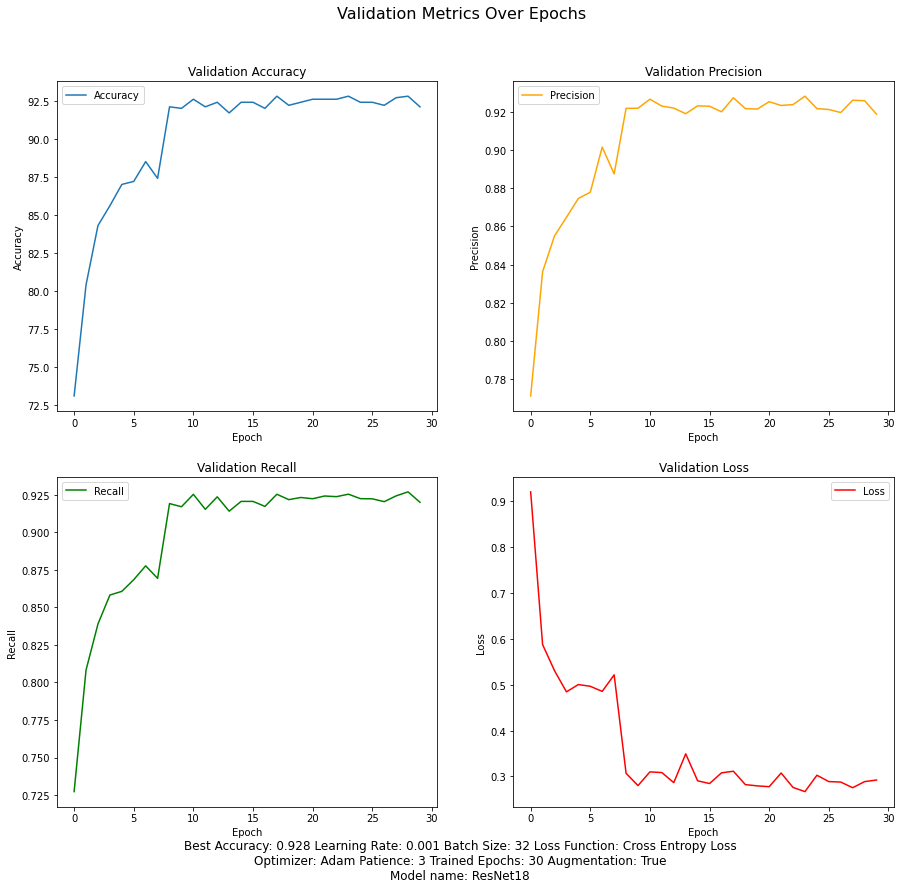

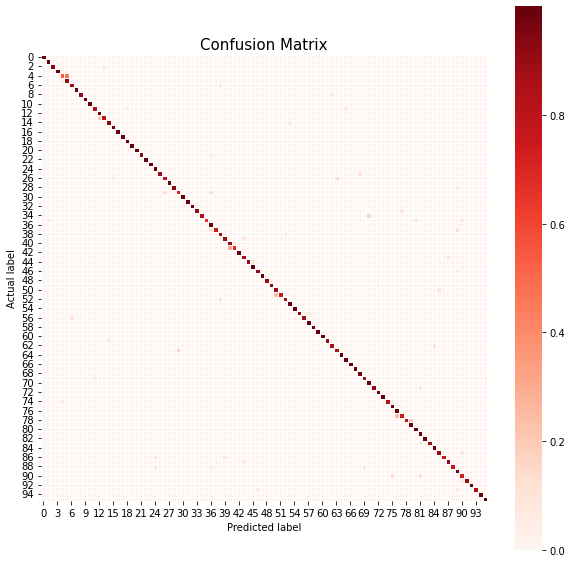

In [48]:
# plot the accuracy and loss in two different plots

# accuracy_list = np.random.randint(0, 100, size=(40))
# precision_list = np.random.randint(0, 100, size=(40))
# recall_list = np.random.randint(0, 100, size=(40))
# f1_list = np.random.randint(0, 100, size=(40))
# loss_list = np.random.randint(0, 100, size=(40))

plt.figure(figsize=(15, 13))

# Subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(accuracy_list, label='Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for precision
plt.subplot(2, 2, 2)
plt.plot(precision_list, label='Precision', color='orange')
plt.title('Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Subplot for recall
plt.subplot(2, 2, 3)
plt.plot(recall_list, label='Recall', color='green')
plt.title('Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Subplot for loss
plt.subplot(2, 2, 4)
plt.plot(loss_list, label='Loss', color='red')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Overall title
plt.suptitle('Validation Metrics Over Epochs', fontsize=16)

# fig_text = f"Best Accuracy: {hyperparameters['best']} \nLearning Rate: {hyperparameters['learning_rate']} \nBatch Size: {hyperparameters['batch_size']} \nPatience: {hyperparameters['patience']} \nTrained Epochs: {hyperparameters['trained_epochs']} \nModel name: {hyperparameters['model_name']} \nAugmentation: True"
best = hyperparameters['best']
lr = hyperparameters['learning_rate']
batch_size = hyperparameters['batch_size']
patience = hyperparameters['patience']
trained_epochs = hyperparameters['trained_epochs']
model_name = hyperparameters['model_name']
augmentation = hyperparameters['augmentation']
crit = "Cross Entropy Loss"
opt = "Adam"
img_size = hyperparameters['image_size']
fig_text = f"Best Accuracy: {best} Learning Rate: {lr} Batch Size: {batch_size} Loss Function: {crit} \nOptimizer: {opt} Patience: {patience} Trained Epochs: {trained_epochs} Augmentation: {augmentation} \nModel name: {model_name} "

plt.figtext(0.5, 0.05, fig_text, wrap=True, horizontalalignment='center', fontsize=12)

plt.subplots_adjust(top=0.9)  # Add space at the top for the overall title
plt.savefig('../plots/metrics_net_5.png')
plt.show()

# conf_matrix = np.random.randint(0, 100, size=(96, 96))

global conf_matrix
conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-7)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=False, linewidths=.5, square = True, cmap = 'Reds')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size = 15)
plt.savefig('../plots/confusion_matrix_net_5.png')
plt.show()



In [19]:
# present misclassified images
model = ResNet().to(device)
optimizer = Adam(model.parameters(), lr=hyperparameters['learning_rate'])

state = torch.load('../models/model_resnet18.pth', map_location=torch.device('cpu'))
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])

# model.eval()
predicted_labels = []
actual_labels = []
with torch.no_grad():
    for images, ids in tqdm(val_loader):
        # images = images.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(ids.tolist())

predicted_labels = np.array(predicted_labels)
actual_labels = np.array(actual_labels)



100%|██████████| 32/32 [00:40<00:00,  1.26s/it]


In [42]:
# print(predicted_labels[:10])
# print(actual_labels[:10])

misclassified = np.where(predicted_labels != actual_labels)
misclassified = misclassified[0]
print(misclassified)


[  5  16  21  26  42  51  86  87 100 101 117 131 132 145 154 180 194 195
 205 208 211 215 217 218 223 226 228 259 263 271 274 275 280 301 316 320
 337 338 351 365 424 443 458 469 485 493 494 528 530 557 581 582 584 592
 593 601 612 614 619 621 628 651 671 690 701 706 713 714 727 758 772 784
 786 827 846 855 862 889 902 915 921 924 936 937 939 940 962 981 985 999]


90


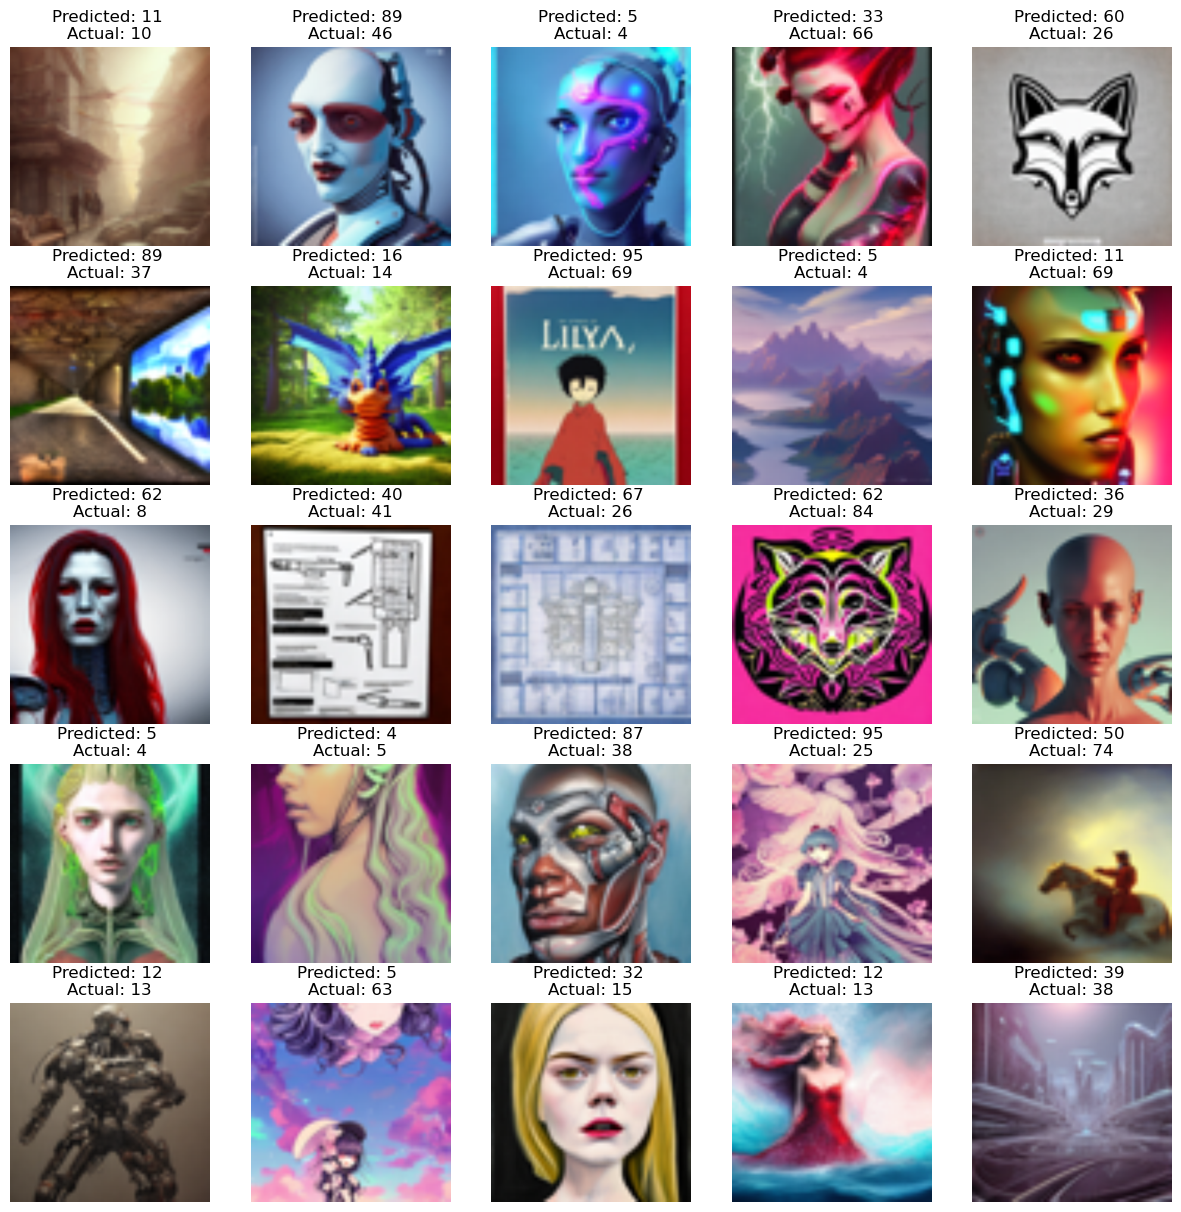

In [60]:
misclassified_images = [val_dataset[x] for x in misclassified]

# convert from tensor to image
misclassified_images = [transforms.ToPILImage()(x[0]) for x in misclassified_images]


print(len(misclassified_images))
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(misclassified_images[i])
    plt.title(f"Predicted: {predicted_labels[misclassified[i]]} \nActual: {actual_labels[misclassified[i]]}")
    plt.axis('off')

plt.savefig('../plots/misclassified_examples.png')
